import data & z-score

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

df = pd.read_csv('traces.csv', low_memory=False)

# drop rejected cells/columns
rejected_columns = df.columns[df.isin([' rejected']).any()]
df = df.drop(columns=rejected_columns)

# Clean up df
df = df.drop(0)
df = df.astype(float)
df = df.rename(columns = {' ': 'Time'})
df['Time'] = df['Time'].round(1)
df = df.set_index(['Time'])

df.columns = df.columns.str.replace(' C', '')
df.columns = df.columns.astype(int)

# transform into zscores
for name, data in df.items():
    df[name] = (df[name] - df[name].mean()) / df[name].std()
df.index.names = ['Time/zscore']

df_z = df
#print(df_z)

PANEL A: Event-Aligned Activity Heatmap

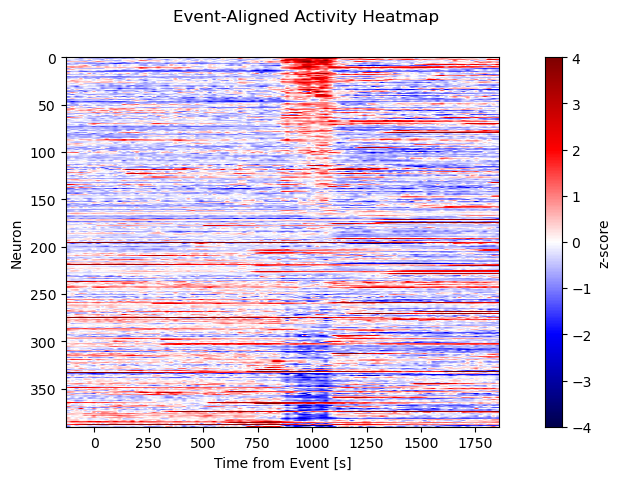

In [2]:
df = df_z.copy(deep=True)
event = 130.5
stat_window = [-1, 1]
vis_window = [-5, 5]
color_border = [-4, 4]

def event_aligned(df):
    # Time=0 at event
    df.index = df.index - event

    # create new dfs for pre and post
    df_pre = df.loc[stat_window[0]:0, :]
    df_post = df.loc[0.1: stat_window[1], :]

    # calculate diff and store in dict
    peri_event_diff = {}
    for col in df.columns:
        diff = df_post[col].mean() - df_pre[col].mean()
        peri_event_diff[col] = diff

    # sort dictionary in ascending order and return list of cells
    sorted_peri_event_diff = [cell for cell, value in sorted(peri_event_diff.items(), key=lambda item: item[1], reverse=True)]
    df = df.reindex(columns=sorted_peri_event_diff)

    # drop every row outside of vis_window
    df = df.loc[vis_window[0] : vis_window[1], :]

    # adapt values 0-1 and clip at color_border
    scale_factor = 1/(color_border[1] - color_border[0])
    df = (df - color_border[0]) * scale_factor
    df = df.clip(0, 1)

    return df


# draw plot
def plot_heatmap_and_gradient(axs, data):
    timeline = list(df.index.values)
    nb_cells = len(data.columns)
    data = data.transpose()
    gradient = np.vstack((np.linspace(1, 0, 256), np.linspace(1, 0, 256)))
    map_color = "seismic"

    im_left = axs[0].imshow(data, cmap=map_color, aspect="auto", extent=[timeline[0], timeline[-1], nb_cells, 0])
    axs[0].set_xlabel("Time from Event [s]")
    axs[0].set_ylabel("Neuron")
    # axs[0].axvline(x=0, color="gray")

    im_right = axs[1].imshow(gradient.T, cmap=map_color, aspect="auto", extent=[0, 1, color_border[0], color_border[1]])
    axs[1].set_ylabel("z-score")
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].set_yticks(np.arange(color_border[0], color_border[1]+1, 1)) 
    axs[1].xaxis.set_visible(False)
    
    return im_left, im_right

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [25, 1]})
im_left, im_right = plot_heatmap_and_gradient(axs, event_aligned(df))
fig.suptitle("Event-Aligned Activity Heatmap")

plt.show()

In [75]:
print(df_z)

                  0         1         2         3         4         5    \
Time/zscore                                                               
0.0         -0.220990 -0.658199  0.801626 -0.409652  0.175014  0.282159   
0.1         -0.293202 -0.433958  1.746225 -0.198631  0.028969 -0.553306   
0.2         -0.303438 -0.181725  0.788736 -0.680465 -0.102565 -0.538871   
0.3         -0.500699 -0.436698  0.866022 -0.394365 -0.031524 -0.305275   
0.4         -0.421207 -0.274628 -0.275260 -0.613201 -0.235941 -0.561962   
...               ...       ...       ...       ...       ...       ...   
1990.3      -0.275349  2.779821  0.133902  0.430361 -0.312798 -0.606036   
1990.4       0.020528  2.237753  0.387063  0.293828  0.111251  0.010744   
1990.5      -0.159318  2.278388 -0.154838  0.844634 -0.016153 -0.928583   
1990.6      -0.219817  2.382881 -0.333440  0.720054  0.264526  0.196820   
1990.7      -0.236438  1.997611 -0.644820  0.502843  0.290591  0.352549   

                  6     

PANEL B: Event-Aligned Responses

In [158]:
df = df_z.copy(deep=True)
#print(df)
events = [130.5, 160.5, 1781.35, 1811.35, 1841.35, 1871.35, 1901.35]
stat_window = [-0.2, 0.2]
vis_window = [-1, 1]
rec_freq = 10   # how many data points per second

# create new df (index are cell numbers) for storing mean pre- and post-activites
df_diff = pd.DataFrame(index=df.columns)
df_diff.index.names = ['Cell/Event']

for i, event in enumerate(events):
    # gets rows with the wanted indexes according to stat_window
    event_pos = df.index.get_loc(round(event, 1))
    pre = df.iloc[int(event_pos+stat_window[0]*rec_freq) : event_pos]
    post = df.iloc[event_pos : int(event_pos+stat_window[1]*rec_freq)]

    # for Wilcoxon, we only need the post-pre-difference
    diff = (post.mean() - pre.mean())

    # insert a column for the difference in post_mean - pre_mean
    df_diff.insert(loc=len(df_diff.columns), column=i, value=diff)
#print(df_diff)

# Wilcoxon signed-rank test
responses = {'up' : [], 'down' : [], 'non' : []}
for i in range(len(df_diff)):
    row = df_diff.iloc[i]
    cell = df_diff.index[i]

    statistic, p_value = stats.wilcoxon(row, alternative='two-sided')

    if p_value <= 0.05:
        responses['up'].append(cell) if np.sum(row) > 0 else responses['down'].append(cell)
    else:
        responses['non'].append(cell)

cell = 0
df_cell = pd.DataFrame(columns=np.arange(vis_window[0], vis_window[1]+0.1, 0.1))
df_cell.index.names = ['Events/Time']

a = pd.Series(df.loc[events[0]+vis_window[0] : events[0]+vis_window[1], 0])


df_cell.loc[0] = a.values
print(df_cell)


                 -1.0     -0.9      -0.8      -0.7      -0.6      -0.5  \
Events/Time                                                              
0           -0.279342 -0.15502 -0.228999 -0.239793 -0.292253 -0.285511   

                 -0.4      -0.3     -0.2      -0.1  ...      0.1       0.2  \
Events/Time                                         ...                      
0           -0.248036 -0.243151 -0.15216 -0.275301  ... -0.42974 -0.492306   

                  0.3       0.4       0.5      0.6       0.7       0.8  \
Events/Time                                                              
0           -0.618267 -0.544045 -0.446609 -0.42959 -0.293127 -0.533868   

                  0.9      1.0  
Events/Time                     
0           -0.353143 -0.25376  

[1 rows x 21 columns]


c:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [139]:
df_cell = pd.DataFrame(columns=[0,1,2,3])
#print(df_cell)

a = pd.Series([5,6,7])
print(a)
df_cell.loc[0] = a

print(df_cell)

0    5
1    6
2    7
dtype: int64
     0    1    2   3
0  5.0  6.0  7.0 NaN
